<p style="font-size:29px"><strong>Retail Marketing Individual Assignment - Alternative Regression Models</strong></p>

Alternative models.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Load-Preprocessed-Data" data-toc-modified-id="Load-Preprocessed-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Preprocessed Data</a></span></li><li><span><a href="#SCAN*PRO-Regression" data-toc-modified-id="SCAN*PRO-Regression-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>SCAN*PRO Regression</a></span><ul class="toc-item"><li><span><a href="#Alternative-1" data-toc-modified-id="Alternative-1-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Alternative 1</a></span><ul class="toc-item"><li><span><a href="#Brand-1" data-toc-modified-id="Brand-1-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Brand 1</a></span></li><li><span><a href="#Brand-2" data-toc-modified-id="Brand-2-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Brand 2</a></span></li><li><span><a href="#Brand-3" data-toc-modified-id="Brand-3-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>Brand 3</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-3.1.4"><span class="toc-item-num">3.1.4&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></li><li><span><a href="#Alternative-2" data-toc-modified-id="Alternative-2-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Alternative 2</a></span><ul class="toc-item"><li><span><a href="#Brand-1" data-toc-modified-id="Brand-1-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Brand 1</a></span></li><li><span><a href="#Brand-2" data-toc-modified-id="Brand-2-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Brand 2</a></span></li><li><span><a href="#Brand-3" data-toc-modified-id="Brand-3-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Brand 3</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></li></ul></li></ul></div>

# Summary

This notebook contains the regression results for two alternative models which were tested alongside the final chosen model detailed in the `01_regression_modelling.ipynb` notebook. The two alternative models evaluate the effect of using the log transformed `FEATURE*` variable instead of the binary encoded version, and the effect of using wholesale prices instead of retail prices. Retail prices may be endogenous variables as they may be set by the store manager depending on how well the sales of the product are doing which can cause bias in the model.

Alternative model 1 (log FEATURE variable) was discounted because the model performed less well on the unseen test data and the coefficients for the `log_FEATURE` variables have very large error bounds which made them difficult to interpret with any confidence.

Alternative model 2 (wholesale prices instead of retail prices) was discounted because the model performance was much worse than the chosen model and the alternative model 1. It was shown that wholesale prices have very little correlation with unit sales whereas retail price was very correlated with unit sales which may be the cause of the poor model performance.

## Imports

In [1]:
import re
import pandas as pd
import numpy as np
import scipy

import calendar

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.nonparametric.smoothers_lowess import  lowess

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from IPython.core.display import display, HTML

import warnings; warnings.simplefilter('ignore')

In [2]:
#visualisation libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

#matplotlib styling
plt.rcParams['font.family'] = 'serif'

In [3]:
pd.set_option('display.max_columns', 500)

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
#custom python files
from utils import *
from constants import *

## Load Preprocessed Data
Load processed data (see 01_regression_modelling.ipynb)

In [6]:
data = pd.read_csv(f"{DATA_FOLDER}/02_processed/all_data.csv", index_col='Unnamed: 0')
train = pd.read_csv(f"{DATA_FOLDER}/02_processed/train.csv", index_col='Unnamed: 0')
test = pd.read_csv(f"{DATA_FOLDER}/02_processed/test.csv", index_col='Unnamed: 0')

In [7]:
data.head()

,CategorySales,PRICEBRAND1,PRICEBRAND2,PRICEBRAND3,display_brand1,display_brand2,display_brand3,FEATUREBRAND1,FEATUREBRAND2,FEATUREBRAND3,RETAILERMARGINBRAND1,RETAILERMARGINBRAND2,RETAILERMARGINBRAND3,SALESBRAND1,SALESBRAND2,SALESBRAND3,WHOLESALEPRICE1,WHOLESALEPRICE2,WHOLESALEPRICE3,UNITSBRAND1,UNITSBRAND2,UNITSBRAND3,log_CategorySales,log_PRICEBRAND1,log_PRICEBRAND2,log_PRICEBRAND3,log_display_brand1,log_display_brand2,log_display_brand3,log_FEATUREBRAND1,log_FEATUREBRAND2,log_FEATUREBRAND3,log_RETAILERMARGINBRAND1,log_RETAILERMARGINBRAND2,log_RETAILERMARGINBRAND3,log_SALESBRAND1,log_SALESBRAND2,log_SALESBRAND3,log_WHOLESALEPRICE1,log_WHOLESALEPRICE2,log_WHOLESALEPRICE3,log_UNITSBRAND1,log_UNITSBRAND2,log_UNITSBRAND3,August,December,February,January,July,June,March,May,November,October,September,binary_FEATUREBRAND1,binary_FEATUREBRAND2,binary_FEATUREBRAND3
1989-06-04,62929.477667,5.005623,4.562936,4.293051,0.000,0.124,0.092,0.0,0.0,0.0,0.120878,0.136304,0.156036,24321.600000,27790.157667,10817.720000,4.011377,4.323338,3.623182,4858,6090,2519,11.049786,1.792696,1.716126,1.666395,0.000000,0.116894,0.088011,0.0,0.0,0.0,0.114112,0.127781,0.144997,10.099161,10.232473,9.289033,1.611711,1.672100,1.531083,8.488588,8.714568,7.832014,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1989-06-11,70907.531666,4.759082,4.666338,4.342844,0.234,0.075,0.089,0.0,0.0,0.0,0.135090,0.089354,0.157650,33005.983333,26466.924333,11434.624000,4.035964,4.333838,3.658193,6935,5671,2632,11.169146,1.750778,1.734543,1.675758,0.210261,0.072321,0.085260,0.0,0.0,0.0,0.126712,0.085585,0.146392,10.404474,10.183689,9.344489,1.616605,1.674071,1.538628,8.844481,8.643297,7.875879,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1989-06-18,67031.204999,4.630858,4.770684,4.913317,0.256,0.119,0.044,0.0,0.0,0.0,0.119915,0.081313,0.123846,34129.983333,26000.576333,6900.645333,4.198608,4.254309,4.304820,7370,5450,1404,11.112928,1.728262,1.752791,1.777207,0.227932,0.112435,0.043059,0.0,0.0,0.0,0.113253,0.078176,0.116757,10.437961,10.165912,8.839515,1.648391,1.659048,1.668616,8.905309,8.603554,7.247793,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1989-06-25,83289.667166,4.222040,4.266464,4.934866,0.105,0.120,0.016,0.0,0.0,0.0,0.129831,0.166255,0.131854,41453.750000,35708.431833,6127.485333,3.712543,3.520105,4.284186,9818,8369,1241,11.330092,1.652888,1.661359,1.780845,0.099845,0.113329,0.015873,0.0,0.0,0.0,0.122068,0.153798,0.123857,10.632358,10.483170,8.720703,1.550228,1.508535,1.664719,9.192075,9.032409,7.124478,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1989-07-02,122057.548834,4.105199,4.103394,4.905153,0.180,0.092,0.000,0.0,0.0,0.0,0.133630,0.124810,0.130308,67620.016667,46842.793500,7594.738667,3.555056,3.592828,4.265970,16471,11415,1548,11.712256,1.630259,1.629906,1.775825,0.165514,0.088011,0.000000,0.0,0.0,0.0,0.125425,0.117614,0.122490,11.121674,10.754574,8.935343,1.516238,1.524496,1.661265,9.709417,9.342771,7.345365,0,0,0,0,1,0,0,0,0,0,0,0,0,0


## SCAN\*PRO Regression

In [8]:
#create a list of months
months = [calendar.month_name[i] for i in range(1,13)]

seasonal_cols = [col for col in data.columns if col in months]
log_feature_cols = get_cols('^log_FEATURE', data.columns)
binary_feature_cols = get_cols('^binary_FEATURE', data.columns)
log_display_cols = get_cols('^log_display', data.columns)
log_price_cols = get_cols('^log_PRICE', data.columns)
log_wholesale_cols = get_cols('^log_WHOLESALE', data.columns)

### Alternative 1

> Use the `log_FEATURE*` variables instead of `binary_FEATURE*` variable

In [9]:
alt1_model_features = (
    log_price_cols +
    log_display_cols +
    log_feature_cols +
    seasonal_cols
)

#### Brand 1

                            OLS Regression Results                            
Dep. Variable:        log_UNITSBRAND1   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     30.33
Date:                Sat, 11 Apr 2020   Prob (F-statistic):           1.45e-42
Time:                        15:04:59   Log-Likelihood:                 74.076
No. Observations:                 170   AIC:                            -106.2
Df Residuals:                     149   BIC:                            -40.30
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 18.8804      1

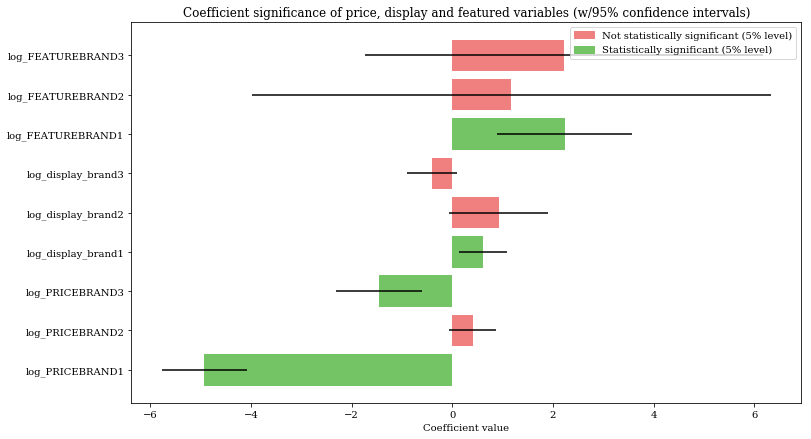

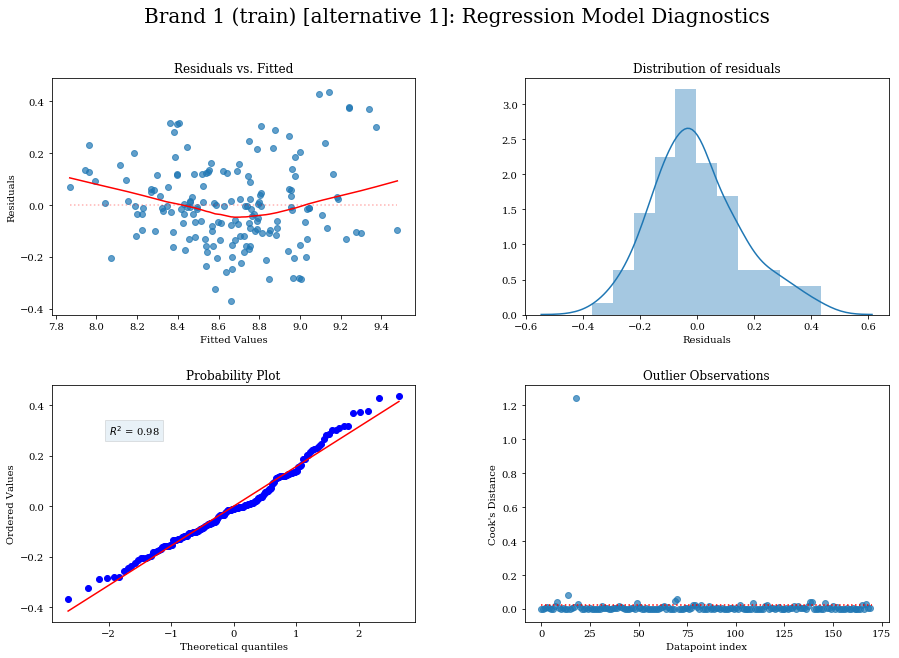

RMSE = 0.1736


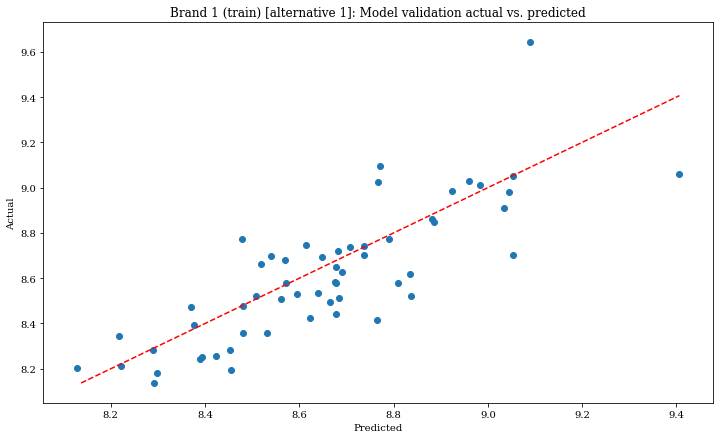

In [10]:
brand1_alt1_model_train = estimate_ols(target_col='log_UNITSBRAND1',
                                   feature_cols=alt1_model_features,
                                   df=train,
                                   model_name='brand1_alt1_model_train')

print(brand1_alt1_model_train.summary())
print("\n"*2)
plot_coef_conf_int(brand1_alt1_model_train)
plt.savefig(f"{VISUALISATION_FOLDER}/brand1_alt1_model_train_significance.png")
plt.show()

plot_diagnostics(brand1_alt1_model_train, "Brand 1 (train) [alternative 1]")
plt.savefig(f"{VISUALISATION_FOLDER}/brand1_alt1_model_train_diagnostics.png")
plt.show()


preds = brand1_alt1_model_train.predict(sm.add_constant(test[alt1_model_features]))

rmse = mean_squared_error(test['log_UNITSBRAND1'],preds)**0.5

print(f"RMSE = {round(rmse,4)}")

plot_preds_versus_actual(preds,test['log_UNITSBRAND1'], "Brand 1 (train) [alternative 1]")
plt.savefig(f"{VISUALISATION_FOLDER}/brand1_alt1_model_train_val.png")
plt.show()

#### Brand 2

                            OLS Regression Results                            
Dep. Variable:        log_UNITSBRAND2   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     32.99
Date:                Sat, 11 Apr 2020   Prob (F-statistic):           1.05e-44
Time:                        15:05:02   Log-Likelihood:                 92.237
No. Observations:                 170   AIC:                            -142.5
Df Residuals:                     149   BIC:                            -76.62
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 16.5544      1

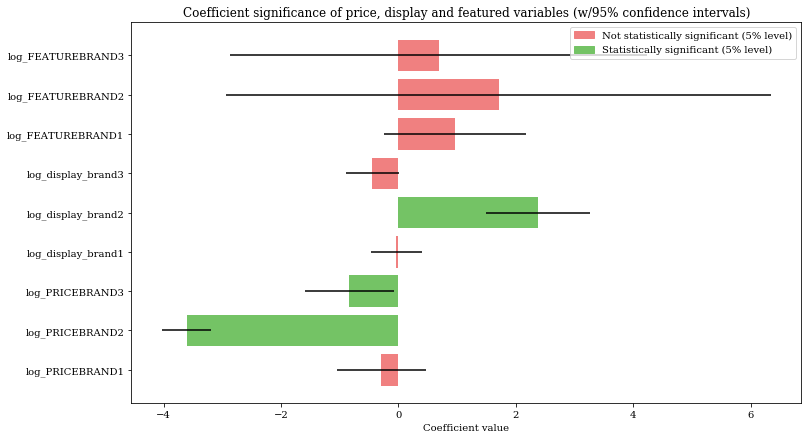

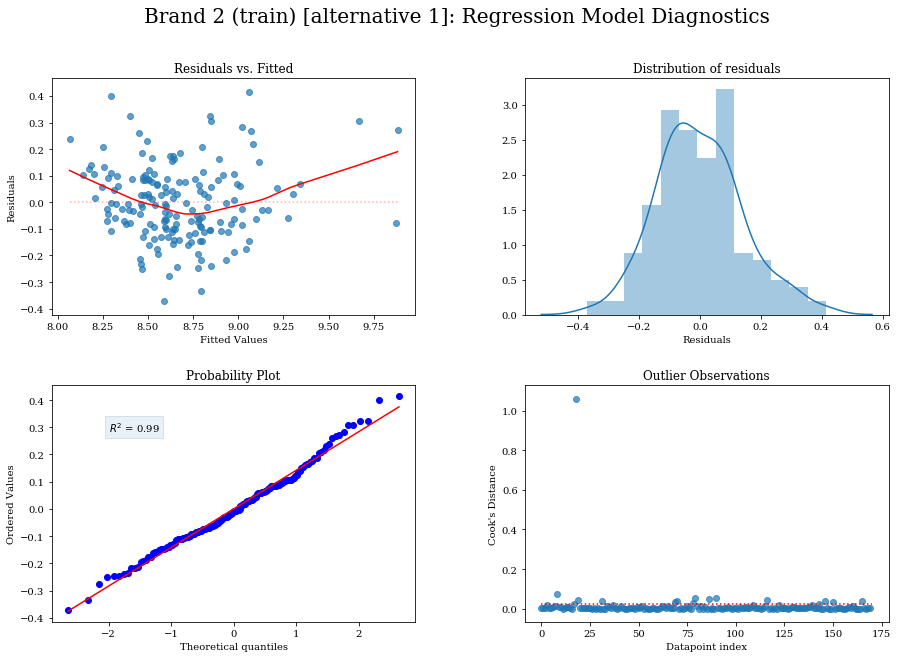

RMSE = 0.1752


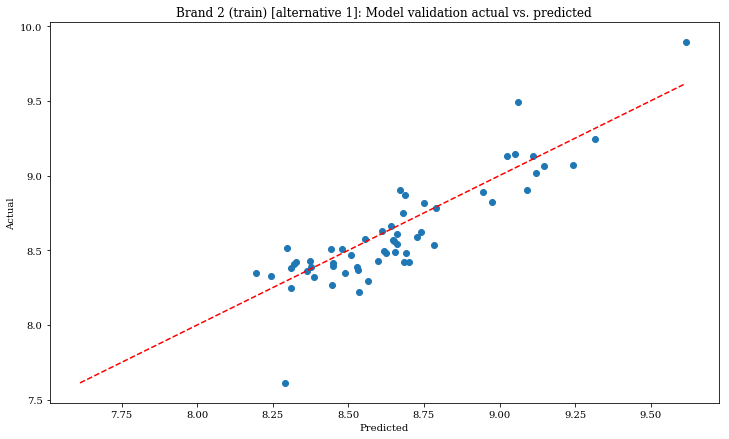

In [11]:
brand2_alt1_model_train = estimate_ols(target_col='log_UNITSBRAND2',
                                   feature_cols=alt1_model_features,
                                   df=train,
                                   model_name='brand2_alt1_model_train')

print(brand2_alt1_model_train.summary())
print("\n"*2)
plot_coef_conf_int(brand2_alt1_model_train)
plt.savefig(f"{VISUALISATION_FOLDER}/brand2_alt1_model_train_significance.png")
plt.show()

plot_diagnostics(brand2_alt1_model_train, "Brand 2 (train) [alternative 1]")
plt.savefig(f"{VISUALISATION_FOLDER}/brand2_alt1_model_train_diagnostics.png")
plt.show()


preds = brand2_alt1_model_train.predict(sm.add_constant(test[alt1_model_features]))

rmse = mean_squared_error(test['log_UNITSBRAND2'],preds)**0.5

print(f"RMSE = {round(rmse,4)}")

plot_preds_versus_actual(preds,test['log_UNITSBRAND2'], "Brand 2 (train) [alternative 1]")
plt.savefig(f"{VISUALISATION_FOLDER}/brand2_alt1_model_train_val.png")
plt.show()

#### Brand 3

                            OLS Regression Results                            
Dep. Variable:        log_UNITSBRAND3   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     32.73
Date:                Sat, 11 Apr 2020   Prob (F-statistic):           1.70e-44
Time:                        15:05:05   Log-Likelihood:                 81.571
No. Observations:                 170   AIC:                            -121.1
Df Residuals:                     149   BIC:                            -55.29
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 14.9081      1

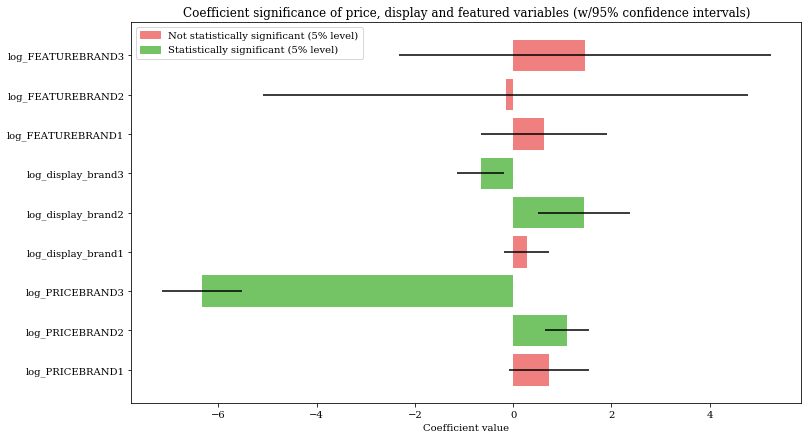

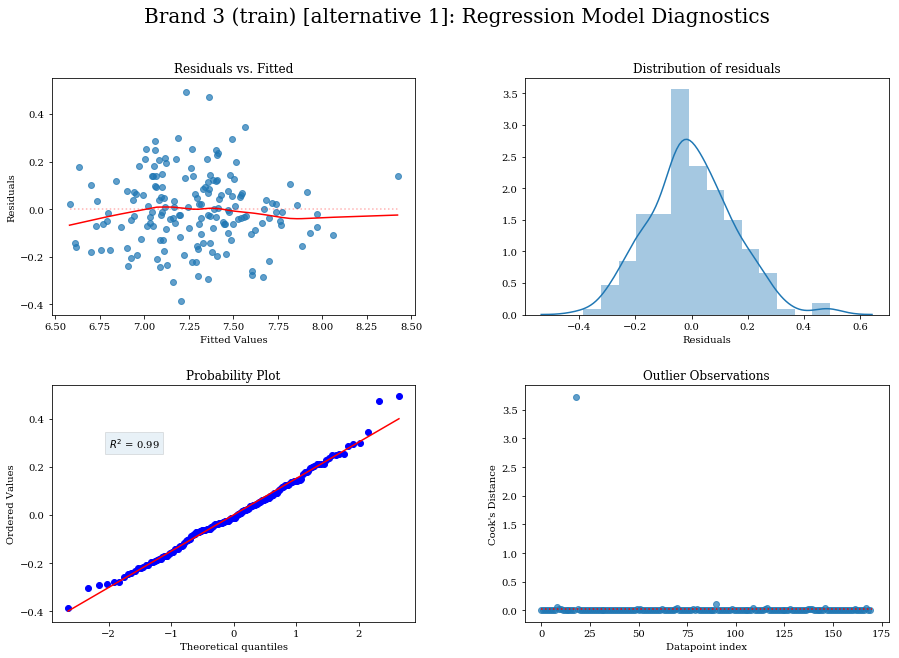

RMSE = 0.1788


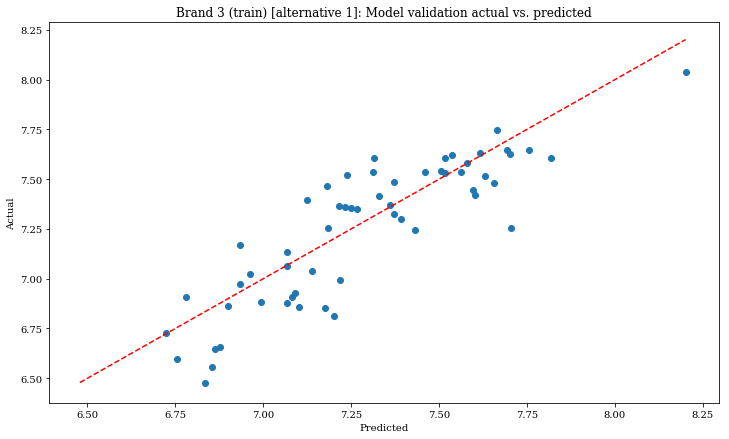

In [12]:
brand3_alt1_model_train = estimate_ols(target_col='log_UNITSBRAND3',
                                   feature_cols=alt1_model_features,
                                   df=train,
                                   model_name='brand3_alt1_model_train')

print(brand3_alt1_model_train.summary())
print("\n"*2)
plot_coef_conf_int(brand3_alt1_model_train)
plt.savefig(f"{VISUALISATION_FOLDER}/brand3_alt1_model_train_significance.png")
plt.show()

plot_diagnostics(brand3_alt1_model_train, "Brand 3 (train) [alternative 1]")
plt.savefig(f"{VISUALISATION_FOLDER}/brand3_alt1_model_train_diagnostics.png")
plt.show()


preds = brand3_alt1_model_train.predict(sm.add_constant(test[alt1_model_features]))

rmse = mean_squared_error(test['log_UNITSBRAND3'],preds)**0.5

print(f"RMSE = {round(rmse,4)}")

plot_preds_versus_actual(preds,test['log_UNITSBRAND3'], "Brand 3 (train) [alternative 1]")
plt.savefig(f"{VISUALISATION_FOLDER}/brand3_alt1_model_train_val.png")
plt.show()

#### Conclusions

The models with the `log_FEATURE*` variables have a similar performance to the original model (see 01_regression_modelling.ipynb) which uses `binary_FEATURE` instead. However, the performance on the test set is slightly worse (RSME ~ 0.17 versus RMSE ~ 0.16 for the original model) than the original model.

The coefficients on the `log_FEATURE` variables have a much higher error range than the original model making them harder to gain useful information. Therefore it appears binary encoding of the FEATURE variable is preferential for modelling.

### Alternative 2

> Use wholesale prices

In [13]:
alt2_model_features = (
    log_wholesale_cols +
    log_display_cols +
    binary_feature_cols +
    seasonal_cols
)

#### Brand 1

                            OLS Regression Results                            
Dep. Variable:        log_UNITSBRAND1   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     17.51
Date:                Sat, 11 Apr 2020   Prob (F-statistic):           1.16e-29
Time:                        15:05:08   Log-Likelihood:                 38.818
No. Observations:                 170   AIC:                            -35.64
Df Residuals:                     149   BIC:                             30.22
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   13.8402 

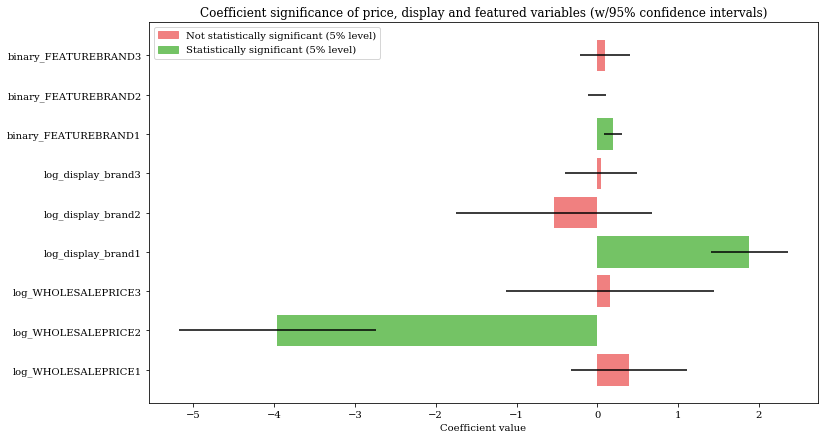

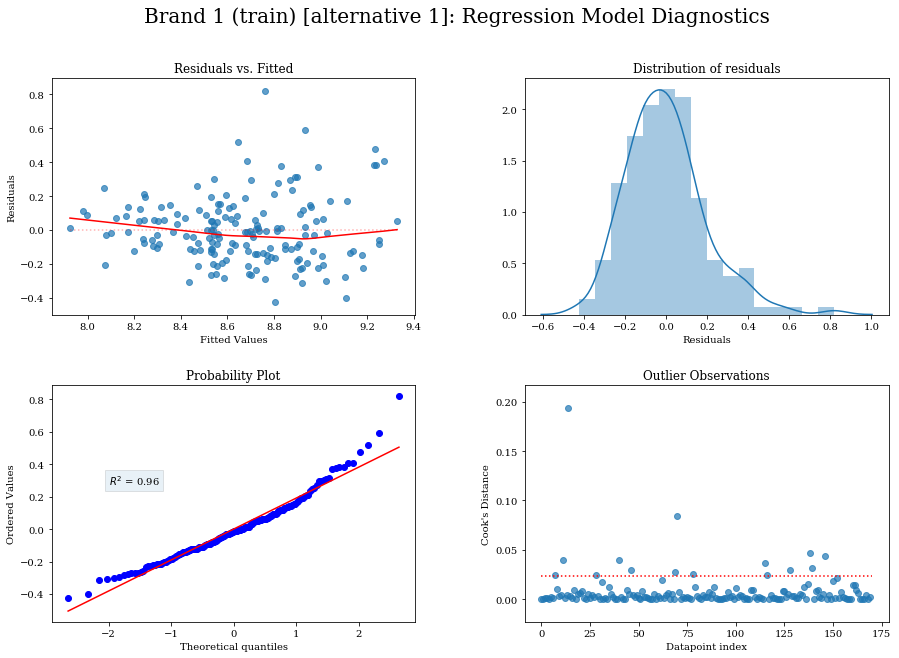

RMSE = 0.2114


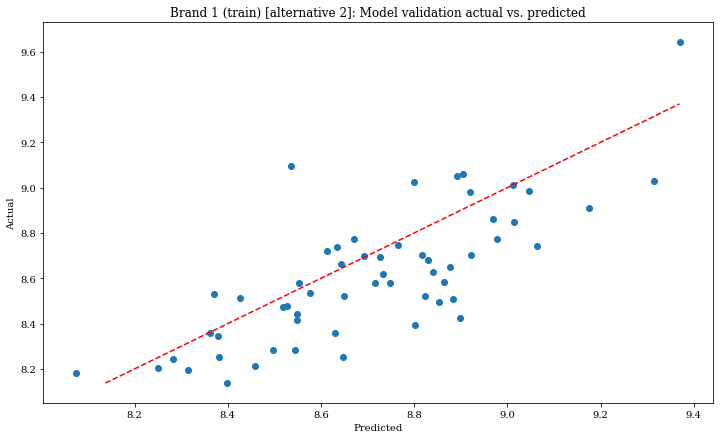

In [14]:
brand1_alt2_model_train = estimate_ols(target_col='log_UNITSBRAND1',
                                   feature_cols=alt2_model_features,
                                   df=train,
                                   model_name='brand1_alt2_model_train')

print(brand1_alt2_model_train.summary())
print("\n"*2)
plot_coef_conf_int(brand1_alt2_model_train)
plt.savefig(f"{VISUALISATION_FOLDER}/brand1_alt2_model_train_significance.png")
plt.show()

plot_diagnostics(brand1_alt2_model_train, "Brand 1 (train) [alternative 1]")
plt.savefig(f"{VISUALISATION_FOLDER}/brand1_alt2_model_train_diagnostics.png")
plt.show()


preds = brand1_alt2_model_train.predict(sm.add_constant(test[alt2_model_features]))

rmse = mean_squared_error(test['log_UNITSBRAND1'],preds)**0.5

print(f"RMSE = {round(rmse,4)}")

plot_preds_versus_actual(preds,test['log_UNITSBRAND1'], "Brand 1 (train) [alternative 2]")
plt.savefig(f"{VISUALISATION_FOLDER}/brand1_alt2_model_train_val.png")
plt.show()

#### Brand 2

                            OLS Regression Results                            
Dep. Variable:        log_UNITSBRAND2   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     11.23
Date:                Sat, 11 Apr 2020   Prob (F-statistic):           6.93e-21
Time:                        15:05:10   Log-Likelihood:                 26.594
No. Observations:                 170   AIC:                            -11.19
Df Residuals:                     149   BIC:                             54.66
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   16.9483 

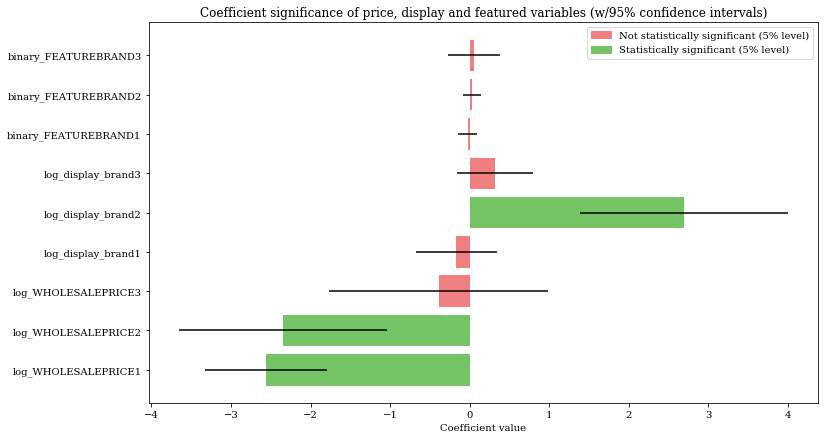

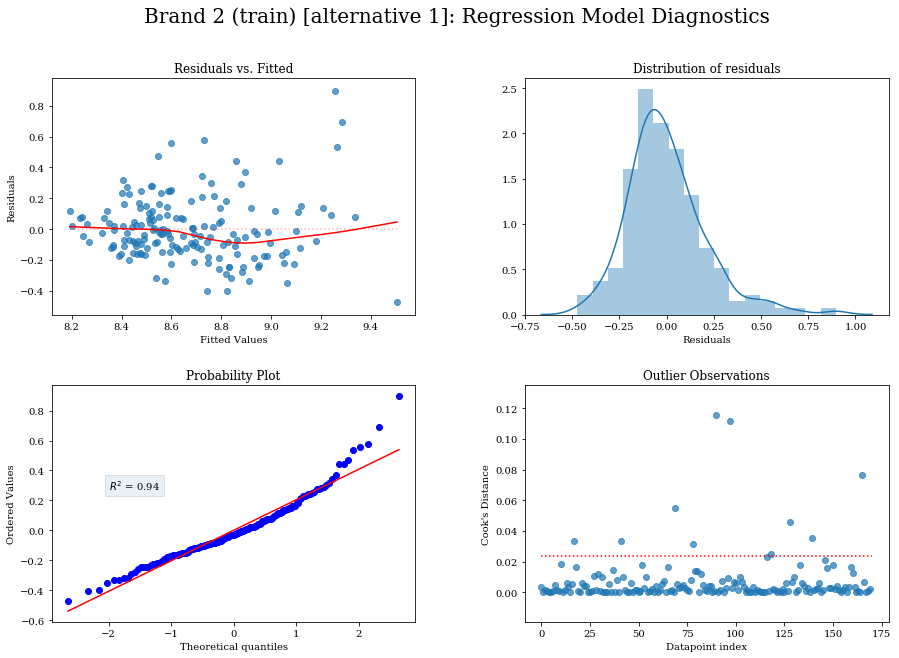

RMSE = 0.25


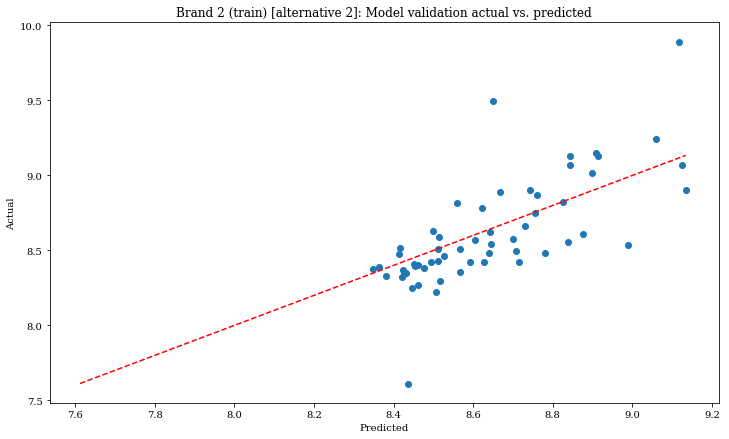

In [15]:
brand2_alt2_model_train = estimate_ols(target_col='log_UNITSBRAND2',
                                   feature_cols=alt2_model_features,
                                   df=train,
                                   model_name='brand2_alt2_model_train')

print(brand2_alt2_model_train.summary())
print("\n"*2)
plot_coef_conf_int(brand2_alt2_model_train)
plt.savefig(f"{VISUALISATION_FOLDER}/brand2_alt2_model_train_significance.png")
plt.show()

plot_diagnostics(brand2_alt2_model_train, "Brand 2 (train) [alternative 1]")
plt.savefig(f"{VISUALISATION_FOLDER}/brand2_alt2_model_train_diagnostics.png")
plt.show()


preds = brand2_alt2_model_train.predict(sm.add_constant(test[alt2_model_features]))

rmse = mean_squared_error(test['log_UNITSBRAND2'],preds)**0.5

print(f"RMSE = {round(rmse,4)}")

plot_preds_versus_actual(preds,test['log_UNITSBRAND2'], "Brand 2 (train) [alternative 2]")
plt.savefig(f"{VISUALISATION_FOLDER}/brand2_alt2_model_train_val.png")
plt.show()

#### Brand 3

                            OLS Regression Results                            
Dep. Variable:        log_UNITSBRAND3   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     19.73
Date:                Sat, 11 Apr 2020   Prob (F-statistic):           2.74e-32
Time:                        15:05:13   Log-Likelihood:                 48.338
No. Observations:                 170   AIC:                            -54.68
Df Residuals:                     149   BIC:                             11.18
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   13.6649 

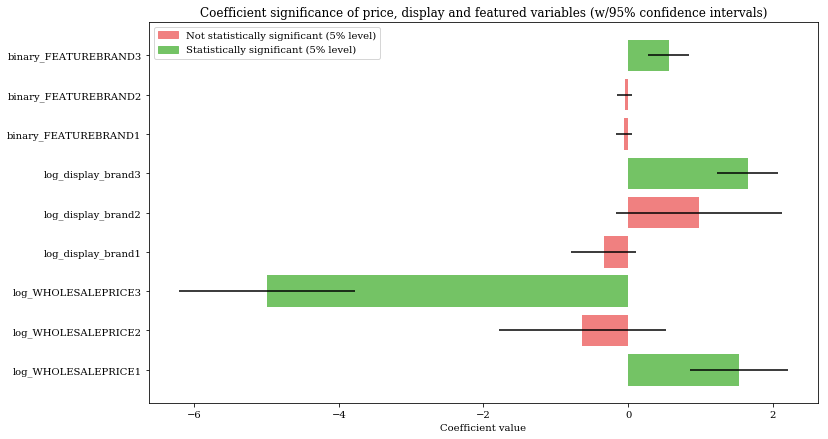

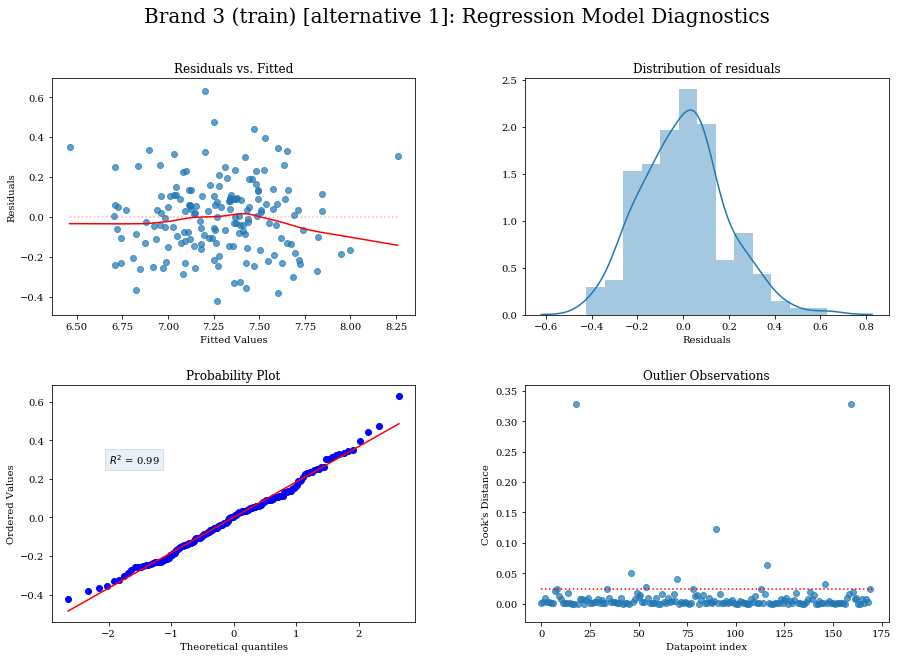

RMSE = 0.2117


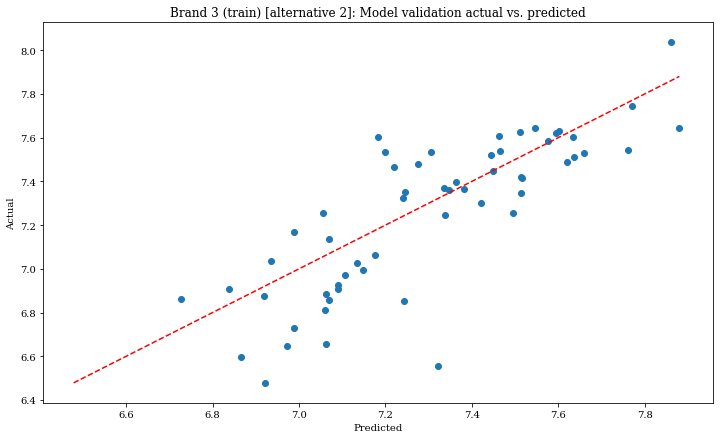

In [16]:
brand3_alt2_model_train = estimate_ols(target_col='log_UNITSBRAND3',
                                   feature_cols=alt2_model_features,
                                   df=train,
                                   model_name='brand3_alt2_model_train')

print(brand3_alt2_model_train.summary())
print("\n"*2)
plot_coef_conf_int(brand3_alt2_model_train)
plt.savefig(f"{VISUALISATION_FOLDER}/brand3_alt2_model_train_significance.png")
plt.show()

plot_diagnostics(brand3_alt2_model_train, "Brand 3 (train) [alternative 1]")
plt.savefig(f"{VISUALISATION_FOLDER}/brand3_alt2_model_train_diagnostics.png")
plt.show()


preds = brand3_alt2_model_train.predict(sm.add_constant(test[alt2_model_features]))

rmse = mean_squared_error(test['log_UNITSBRAND3'],preds)**0.5

print(f"RMSE = {round(rmse,4)}")

plot_preds_versus_actual(preds,test['log_UNITSBRAND3'], "Brand 3 (train) [alternative 2]")
plt.savefig(f"{VISUALISATION_FOLDER}/brand3_alt2_model_train_val.png")
plt.show()

#### Conclusions

The performance of the models using wholesale prices is much worse compared to using retail prices. This is likely because units sales have a low correlation with wholesale prices

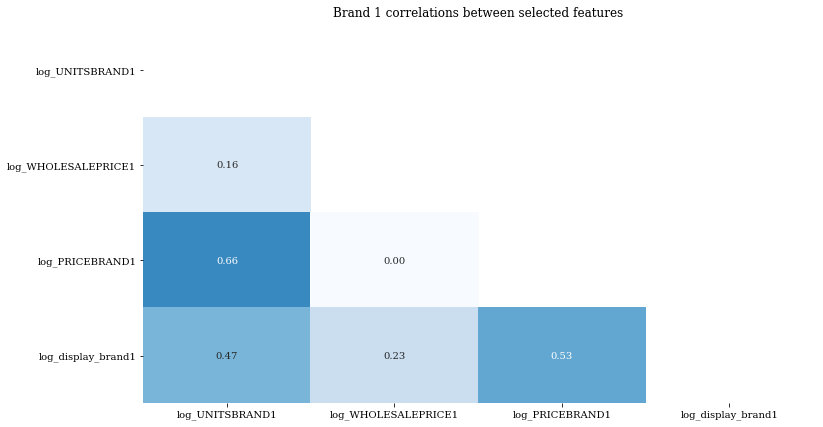

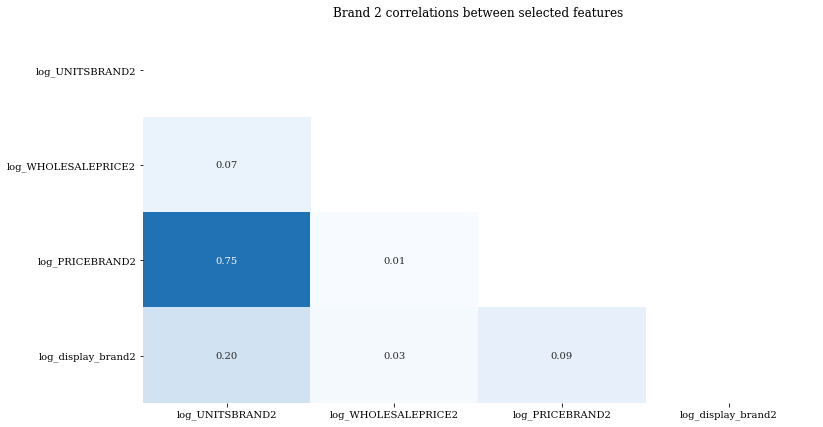

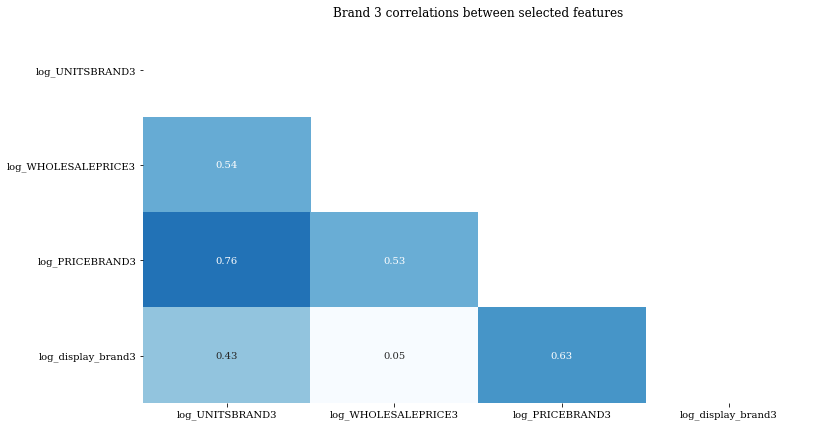

In [17]:
def plot_corr(brand):
    
    corr = abs(data[[f'log_UNITSBRAND{brand}',
                     f'log_WHOLESALEPRICE{brand}',
                     f'log_PRICEBRAND{brand}',
                     f'log_display_brand{brand}']].corr())

    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    sns.heatmap(corr,mask=mask, annot=True, fmt='.2f',cmap='Blues', cbar=False)
    plt.title(f"Brand {brand} correlations between selected features")
    plt.show()
    print("\n"*3)
    
plot_corr(1)
plot_corr(2)
plot_corr(3)